Let's look at the latest database of Gamma Ray Bursts.

- The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
- You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html
T
his edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. Be creative! You're discovering

Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed?

In [72]:
import requests
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

In [76]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Upload data
data = np.genfromtxt("Summary_table.txt", dtype='str', comments="#", autostrip=True)

# Find the headers
with open("Summary_table.txt", 'r') as f:
    header_line = f.readlines()[1]
names = np.array([n.strip().replace(" ", "_") for n in header_line.replace("#","").strip().split('    ') if n.strip() != ''])

# Find numerical columns
numeric_indices = []
for i in range(data.shape[1]):
    try:
        data[:, i].astype(float)
        numeric_indices.append(i)
    except ValueError:
        pass

formatted_data = data[:, numeric_indices].astype(float)

print("Data shape:", formatted_data.shape)
print("Used columns:", names[numeric_indices])

Data shape: (8721, 10)
Used columns: ['ra' 'decl' 'pos_error' 'T90' 'T90_error' 'fluence' 'fluence_error'
 'redshift' "'T100'" 'mjd_(T0)']


In [77]:
print(names, '\n')
for i in range(len(names)):
    print(data[i])

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)'] 

['GRB250424A' 'None' '6:52:13.431' '217.5000' '-35.0252' '0.000082' '-999'
 '-999' '-999' '-999' '-999' '0.3100' '-999' 'False' '60789.28626656']
['GRB250421A' 'GRB250421443' '10:38:30.832' '249.0600' '-59.8600'
 '3.920132' '10.2400' '0.9230' '10:38:30.832' '2.5096e-06' '3.0285e-08'
 '-999' '10.2400' 'True' '60786.44341241']
['GRB250416C' 'None' '17:53:59' '256.4228' '25.7755' '-999' '-999' '-999'
 '-999' '-999' '-999' '0.9630' '-999' 'False' '60781.74582176']
['GRB250416B' 'None' '15:46:42' '103.8000' '-62.2000' '-999' '-999' '-999'
 '-999' '-999' '-999' '-999' '-999' 'True' '60781.65743056']
['GRB250416A' 'GRB250416588' '14:06:21' '323.8000' '70.4900' '-999'
 '22.7840' '1.0560' '14:06:25.497' '3.8016e-05' '6.7097e-08' '-999'
 '27.2810' 'True' '60781.58774306']
['GRB250412A*' 'GRB250412754' '18:06:06.505' '349.8400' '-81.67

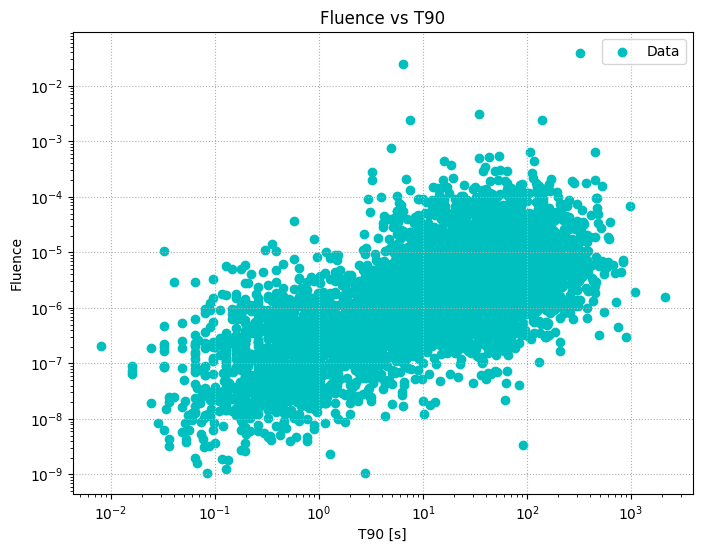

In [87]:
# Plot Time-Flux

T90 = data[:, names == 'T90'].astype(float).flatten()
fluence = data[:, names == 'fluence'].astype(float).flatten()

# Maschera per togliere valori invalidi
mask = (T90 != -999) & (fluence != -999)
T90 = T90[mask]
fluence = fluence[mask]

# Plot
plt.figure(figsize=(8,6))
plt.scatter(T90, fluence, color='c', label='Data')
plt.xscale('log')
plt.yscale('log')
plt.title('Fluence vs T90')
plt.xlabel('T90 [s]')
plt.ylabel('Fluence')
plt.grid(linestyle=':')
plt.legend()
plt.show()


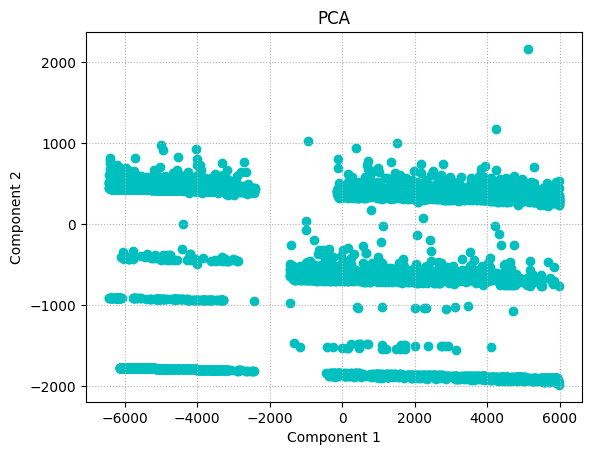

In [ ]:
# PCA

pca = PCA(n_components=2) # 2 components
reduced_data= pca.fit_transform(formatted_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='c')
plt.title('PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(linestyle=':')
plt.show()

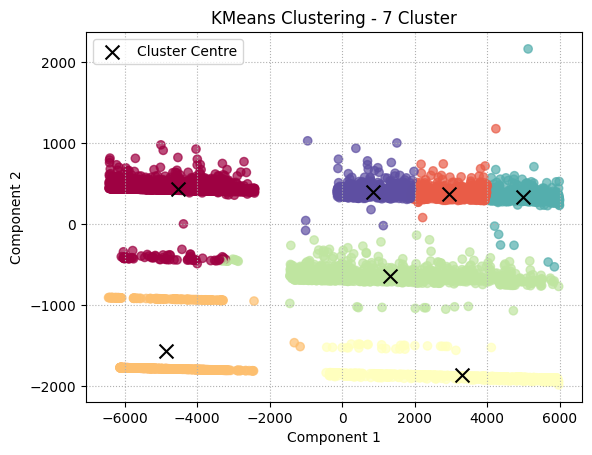

In [149]:
# KMeans Clustering
scaler = StandardScaler()
reduced_data_scaled = scaler.fit_transform(reduced_data)

n_clusters = 7
clf = KMeans(n_clusters=n_clusters, n_init='auto')
clf.fit(reduced_data_scaled)

centers = scaler.inverse_transform(clf.cluster_centers_)
labels = clf.labels_

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='Spectral', alpha=0.7)
plt.scatter(centers[:, 0], centers[:, 1], c='k', marker='x', s=100, label='Cluster Centre')
plt.title(f'KMeans Clustering - {n_clusters} Cluster')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(linestyle=':')
plt.show()

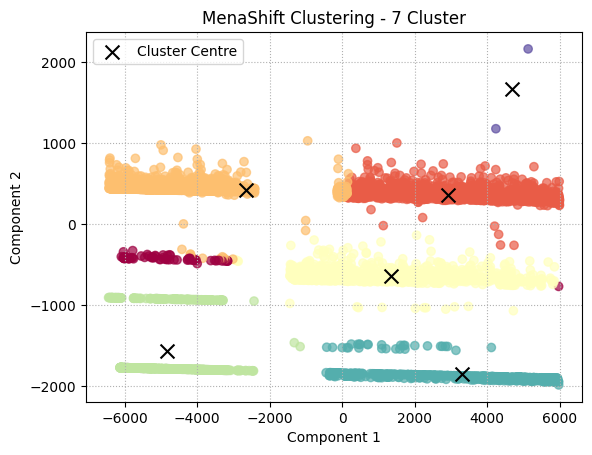

Number of cluster: 7


In [ ]:
# MeanShift clustering
scaler = StandardScaler()
reduced_data_scaled = scaler.fit_transform(reduced_data)

bandwidth = estimate_bandwidth(reduced_data_scaled, quantile=0.3, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms.fit(reduced_data_scaled) 

labels = ms.labels_
n_clusters = len(set(labels))  
centers = scaler.inverse_transform(ms.cluster_centers_)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='Spectral', alpha=0.7)
plt.scatter(centers[:, 0], centers[:, 1], c='k', marker='x', s=100, label='Cluster Centre')
plt.title(f'MenaShift Clustering - {n_clusters} Cluster')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(linestyle=':')
plt.show()